In [1]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scirpy as ir
import numpy as np
import pathlib
import muon as mu
from muon import prot as pt
import os
import numpy as np
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import glob

def tissue_colors():
    tissue_color_dict = {
             'PBMC': '#d6616b',
             'BM': '#cedb9c',
             'LN': '#8c6d31',
             'SPL': '#393b79'}
    return tissue_color_dict

overload = False
if overload == True:
    output_dir='figures/overload'
else:
    output_dir = "figures/no_overload"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save = 300)
sc.set_figure_params(format = 'png')
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None
donor = 'TBD6'
data = '/home/michaelswift/repos/tabula-bursa/data/10X'
samples = ['LN', 'SPL', 'PBMC', 'BM']

def load_data(samplenames, data, donor, overload, tenX_output):
    """samplename is a list of samplenames / tissue names, 
    data is where the data were downloaded
    donor is the name of the donor
    all of these info are used to create the file path
    """
    mdatas = []
    for sample in samples:
        if tenX_output == 'raw':
            datapath = '{}/{}_{}/outs/multi/count/raw_feature_bc_matrix/'.format(data, donor, sample)
            print(datapath)
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
        if tenX_output == 'filtered':
            datapath = '{}/{}_{}/outs/per_sample_outs/{}_{}/count/sample_feature_bc_matrix/'.format(data, donor, sample, donor ,sample)
            print(datapath)
            
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
    adatas = []
    for mdata in mdatas:
        adata = mdata['rna']
        adatas.append(adata)
    if overload == True:
        analysis = "with_overload"
    else:
        analysis = "without_overload"
    if overload:
    # hard coded number of samples right now
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], adatas[6], adatas[7])
    else:
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3])
    return adata

def perform_qc(adata):    
    # calculate qc metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    #adata = adata[:,~adata.var.index.str.contains('HSP|DNAJ')]
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    sc.pl.highest_expr_genes(adata,save='prefilter')
    # plot qc metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='prefilter')
    # cell filter
    sc.pp.filter_cells(adata, min_counts=500)
    sc.pp.filter_cells(adata, max_counts=80000)
    adata = adata[adata.obs['pct_counts_mt'] < 9]
    # plot results of filtering
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='postfilter')
    sc.pl.highest_expr_genes(adata, save='postfilter')
    return adata

In [2]:
def cluster(adata, batch_correct=False, batch_key='tissue'):
    sc.pp.pca(adata)
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = 'batch')
    return adata


def _merge_adata_vdj(vdj, adata):
    # construct merge columns
    adata.obs['cb_index']=adata.obs.index
    adata.obs['cb'] = adata.obs['cb_index'].str.split('-', expand=True)[0]
    adata.obs['cb_sample_id'] = adata.obs['cb'].astype(str) + '_' + adata.obs['tissue'].astype(str)
    vdj['cb_sample_id'] = vdj['cb'] + '_' + vdj['sample_id']
    # PBL vs PBMC
    vdj['cb_sample_id'] = vdj['cb_sample_id'].str.replace('PBL', 'PBMC')
    print(vdj.shape[0], "vdj / cbs")
    print(vdj.drop_duplicates('cb_sample_id').shape[0], "single vdj with single cb")
    print('dropping multiple vdj cbs')
    vdj = vdj.drop_duplicates('cb_sample_id')
    print('merging vdjs gex')
    merged = pd.merge(adata.obs, vdj, left_on='cb_sample_id', right_on='cb_sample_id')
    print(merged.shape[0], "cells after merging VDJs")
    merged.set_index('cb_index', inplace=True)
    adata = adata[adata.obs.index.isin(merged.index)]
    adata.obs = merged
    return adata

In [3]:
# load TBD6's
decontXh5ads = glob.glob('/home/michaelswift/repos/shared_data/TBD6/*decont*')

_adatas = []
for h5 in decontXh5ads:
    _adata = sc.read_h5ad(h5)
    _adatas.append(_adata)

In [4]:
_adatas[0].obs

tissue batch              cb_x         cb_sample_id  \
BM_AAACCTGAGAAGGTTT-1-3     BM     3  AAACCTGAGAAGGTTT  AAACCTGAGAAGGTTT_BM   
BM_AAACCTGAGACAATAC-1-3     BM     3  AAACCTGAGACAATAC  AAACCTGAGACAATAC_BM   
BM_AAACCTGAGACTGGGT-1-3     BM     3  AAACCTGAGACTGGGT  AAACCTGAGACTGGGT_BM   
BM_AAACCTGAGAGGTAGA-1-3     BM     3  AAACCTGAGAGGTAGA  AAACCTGAGAGGTAGA_BM   
BM_AAACCTGAGCCACCTG-1-3     BM     3  AAACCTGAGCCACCTG  AAACCTGAGCCACCTG_BM   
...                        ...   ...               ...                  ...   
BM_TTTGTCAGTTGCGCAC-1-3     BM     3  TTTGTCAGTTGCGCAC  TTTGTCAGTTGCGCAC_BM   
BM_TTTGTCATCTCCAACC-1-3     BM     3  TTTGTCATCTCCAACC  TTTGTCATCTCCAACC_BM   
BM_TTTGTCATCTCCCTGA-1-3     BM     3  TTTGTCATCTCCCTGA  TTTGTCATCTCCCTGA_BM   
BM_TTTGTCATCTCTGCTG-1-3     BM     3  TTTGTCATCTCTGCTG  TTTGTCATCTCTGCTG_BM   
BM_TTTGTCATCTTTACGT-1-3     BM     3  TTTGTCATCTTTACGT  TTTGTCATCTTTACGT_BM   

                        sample_id              cb_y  \
BM_AAACCTGAGAAGGTTT-1-3        BM  AAACCTGAGAAGGTTT   
BM_AAACCTGAGACAATAC-1-3        BM  AAACCTGAGACAATAC   
BM_AAACCTGAGACTGGGT-1-3        BM  AAACCTGAGACTGGGT   
BM_AAACCTGAGAGGTAGA-1-3        BM  AAACCTGAGAGGTAGA   
BM_AAACCTGAGCCACCTG-1-3        BM  AAACCTGAGCCACCTG   
...                           ...               ...   
BM_TTTGTCAGTTGCGCAC-1-3        BM  TTTGTCAGTTGCGCAC   
BM_TTTGTCATCTCCAACC-1-3        BM  TTTGTCATCTCCAACC   
BM_TTTGTCATCTCCCTGA-1-3        BM  TTTGTCATCTCCCTGA   
BM_TTTGTCATCTCTGCTG-1-3        BM  TTTGTCATCTCTGCTG   
BM_TTTGTCATCTTTACGT-1-3        BM  TTTGTCATCTTTACGT   

                                                                 vdjc_info  \
BM_AAACCTGAGAAGGTTT-1-3  ('GAGGTGCAGCTGTTAGAGTCTGGGGGAGACTTGGTACAGCCTGG...   
BM_AAACCTGAGACAATAC-1-3  ('CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTC...   
BM_AAACCTGAGACTGGGT-1-3  ('CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGG...   
BM_AAACCTGAGAGGTAGA-1-3  ('GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGG...   
BM_AAACCTGAGCCACCTG-1-3  ('GAGGTGCAGCTGGTGGAGTCTGGAGGAGGCTTGATCCAGCCTGG...   
...                                                                    ...   
BM_TTTGTCAGTTGCGCAC-1-3  ('GAGGTGCAGCTGGTTGAATCTGGGGGAGGCCTGGTCAAGCCTGG...   
BM_TTTGTCATCTCCAACC-1-3  ('CAGGTGCAGTTGGTGCAGTCTGCGGCTGAGGTGAAGAAGCCTGG...   
BM_TTTGTCATCTCCCTGA-1-3  ('CAGGTGCAGCTGCTGCAGTCTGAGACAGAGGTGCAGGAGCCTGG...   
BM_TTTGTCATCTCTGCTG-1-3  ('GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGG...   
BM_TTTGTCATCTTTACGT-1-3  ('GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGG...   

                                                              vdj_sequence  \
BM_AAACCTGAGAAGGTTT-1-3  GAGGTGCAGCTGTTAGAGTCTGGGGGAGACTTGGTACAGCCTGGGG...   
BM_AAACCTGAGACAATAC-1-3  CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...   
BM_AAACCTGAGACTGGGT-1-3  CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGG...   
BM_AAACCTGAGAGGTAGA-1-3  GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...   
BM_AAACCTGAGCCACCTG-1-3  GAGGTGCAGCTGGTGGAGTCTGGAGGAGGCTTGATCCAGCCTGGGG...   
...                                                                    ...   
BM_TTTGTCAGTTGCGCAC-1-3  GAGGTGCAGCTGGTTGAATCTGGGGGAGGCCTGGTCAAGCCTGGGG...   
BM_TTTGTCATCTCCAACC-1-3  CAGGTGCAGTTGGTGCAGTCTGCGGCTGAGGTGAAGAAGCCTGGGG...   
BM_TTTGTCATCTCCCTGA-1-3  CAGGTGCAGCTGCTGCAGTCTGAGACAGAGGTGCAGGAGCCTGGGG...   
BM_TTTGTCATCTCTGCTG-1-3  GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGGGG...   
BM_TTTGTCATCTTTACGT-1-3  GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...   

                        c_call  n_umis  ...  v_mismatch v_gapopen v_qstart  \
BM_AAACCTGAGAAGGTTT-1-3  IGHG1     5.0  ...        29.0       0.0      1.0   
BM_AAACCTGAGACAATAC-1-3   IGHM     6.0  ...         0.0       0.0      1.0   
BM_AAACCTGAGACTGGGT-1-3   IGHM     9.0  ...         0.0       0.0      1.0   
BM_AAACCTGAGAGGTAGA-1-3   IGHM     2.0  ...         0.0       0.0      1.0   
BM_AAACCTGAGCCACCTG-1-3   IGHM     7.0  ...         0.0       0.0      1.0   
...                        ...     ...  ...         ...       ...      .

In [5]:
adata = _adatas[0].concatenate(_adatas[1:])

In [6]:
adata.obs.tissue.value_counts()

LN      10422
PBMC    10309
SPL      8967
BM       6490
Name: tissue, dtype: int64

In [7]:
adata_2 = sc.read_h5ad('/home/michaelswift/repos/seqclone3/notebooks/data/forseqclone.h5ad')
adata_2.obs['tissue'] = adata_2.obs.lane
print(adata_2.shape[0], "cells in comparison dataset")
adata = adata.concatenate(adata_2)

print(adata.shape[0], 'cells in combined dataset')

84380 cells in comparison dataset
120568 cells in combined dataset


## Filter out worst cells

In [8]:
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, max_counts=80000)

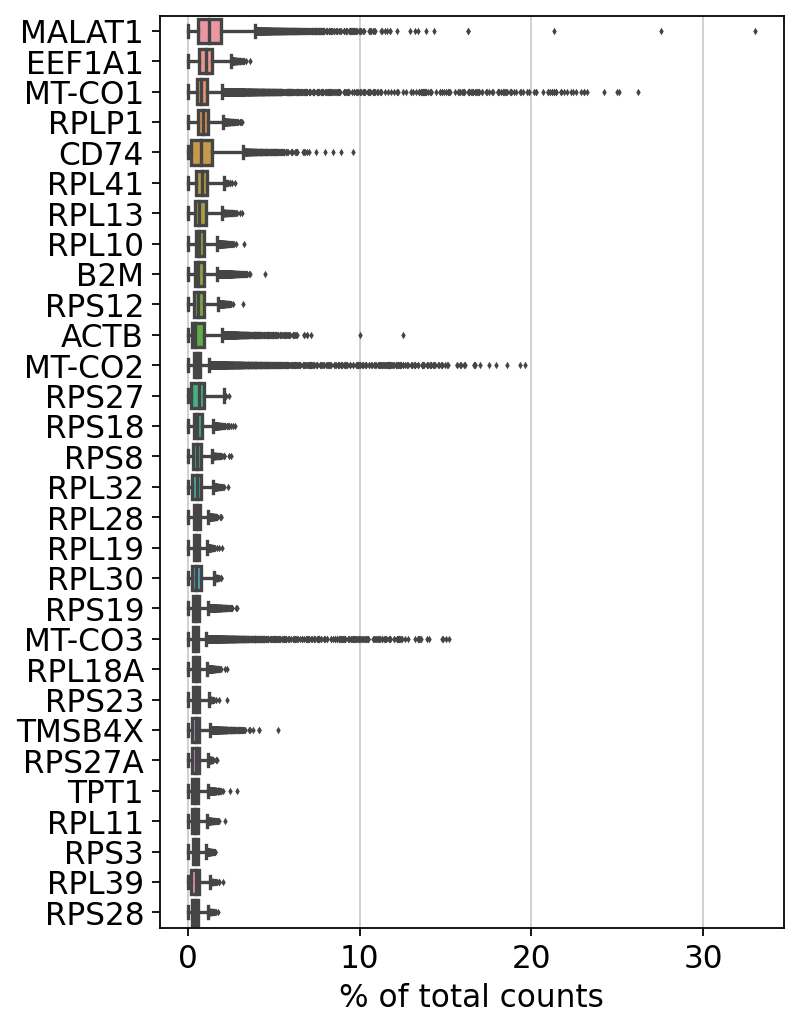

... storing 'tissue' as categorical
... storing 'cb_x' as categorical
... storing 'cb_sample_id' as categorical
... storing 'sample_id' as categorical
... storing 'cb_y' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignment' as categorical
... storing 'd_sequence_alignment_aa' as categorical
... storing 'd_germline_alignment' as categorical
... storing 'd_germline_alignment_aa' as categorical
... storing 'j_sequence_alignment' as categorical
..

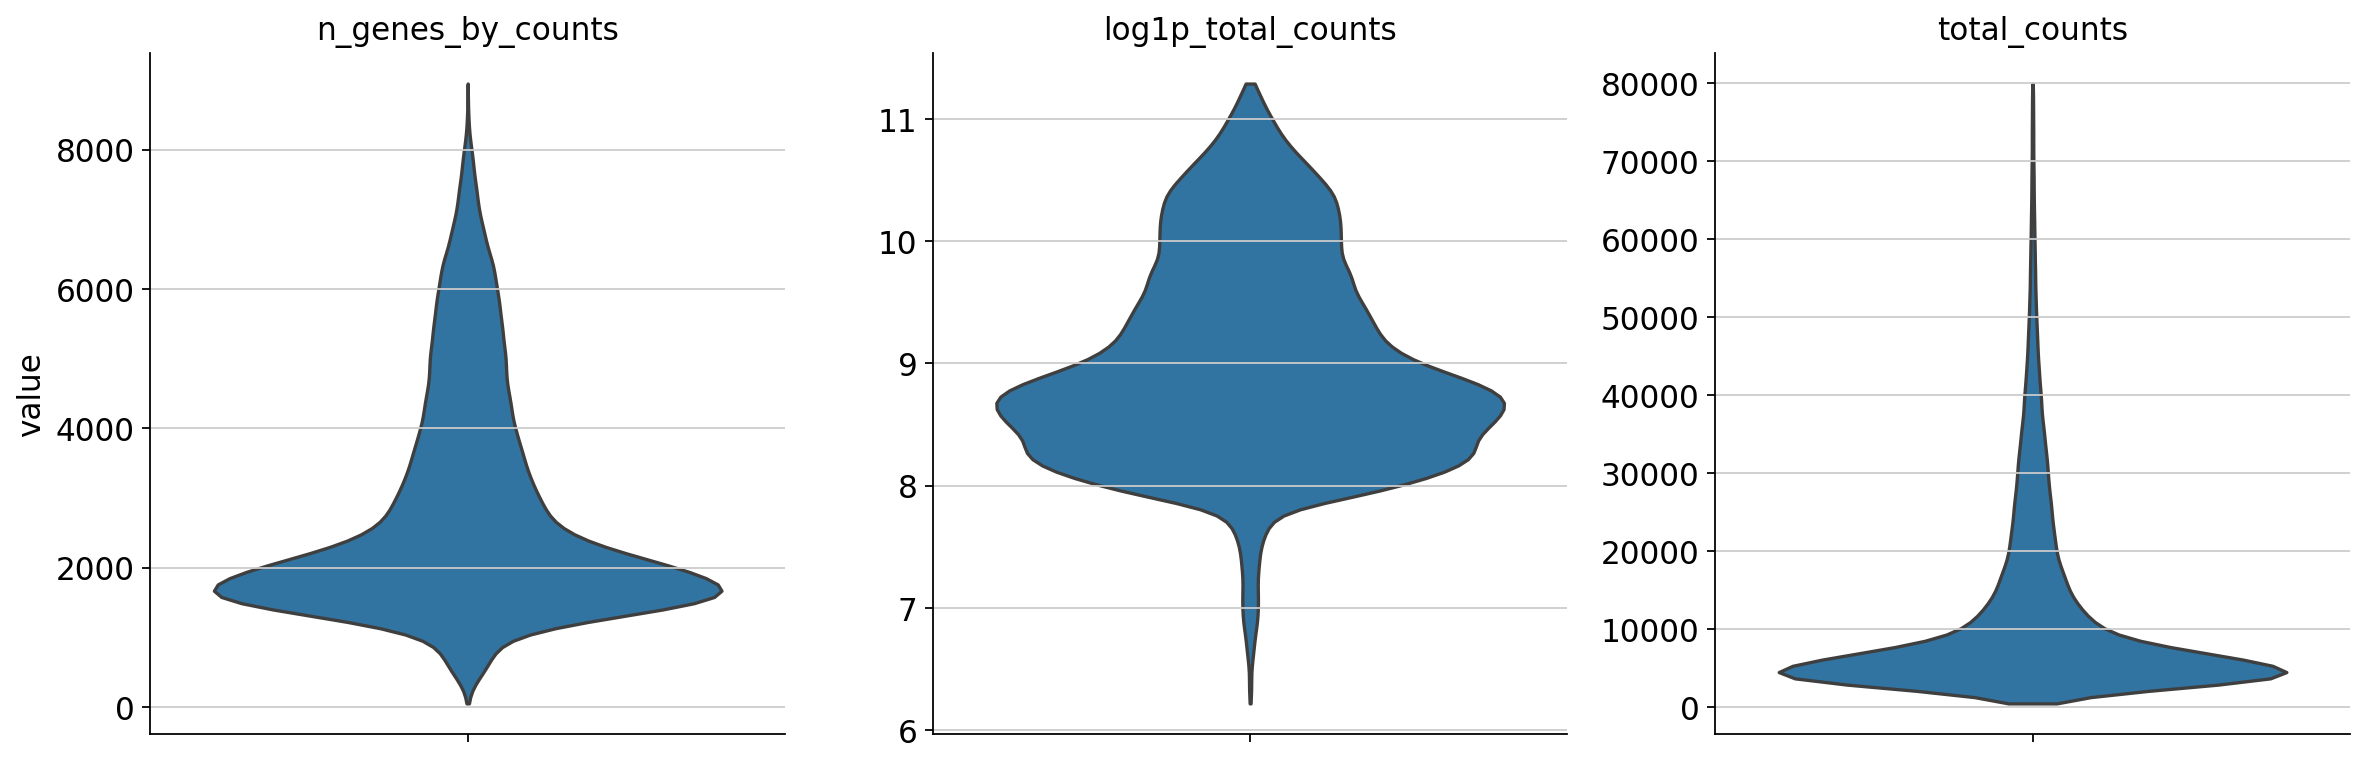

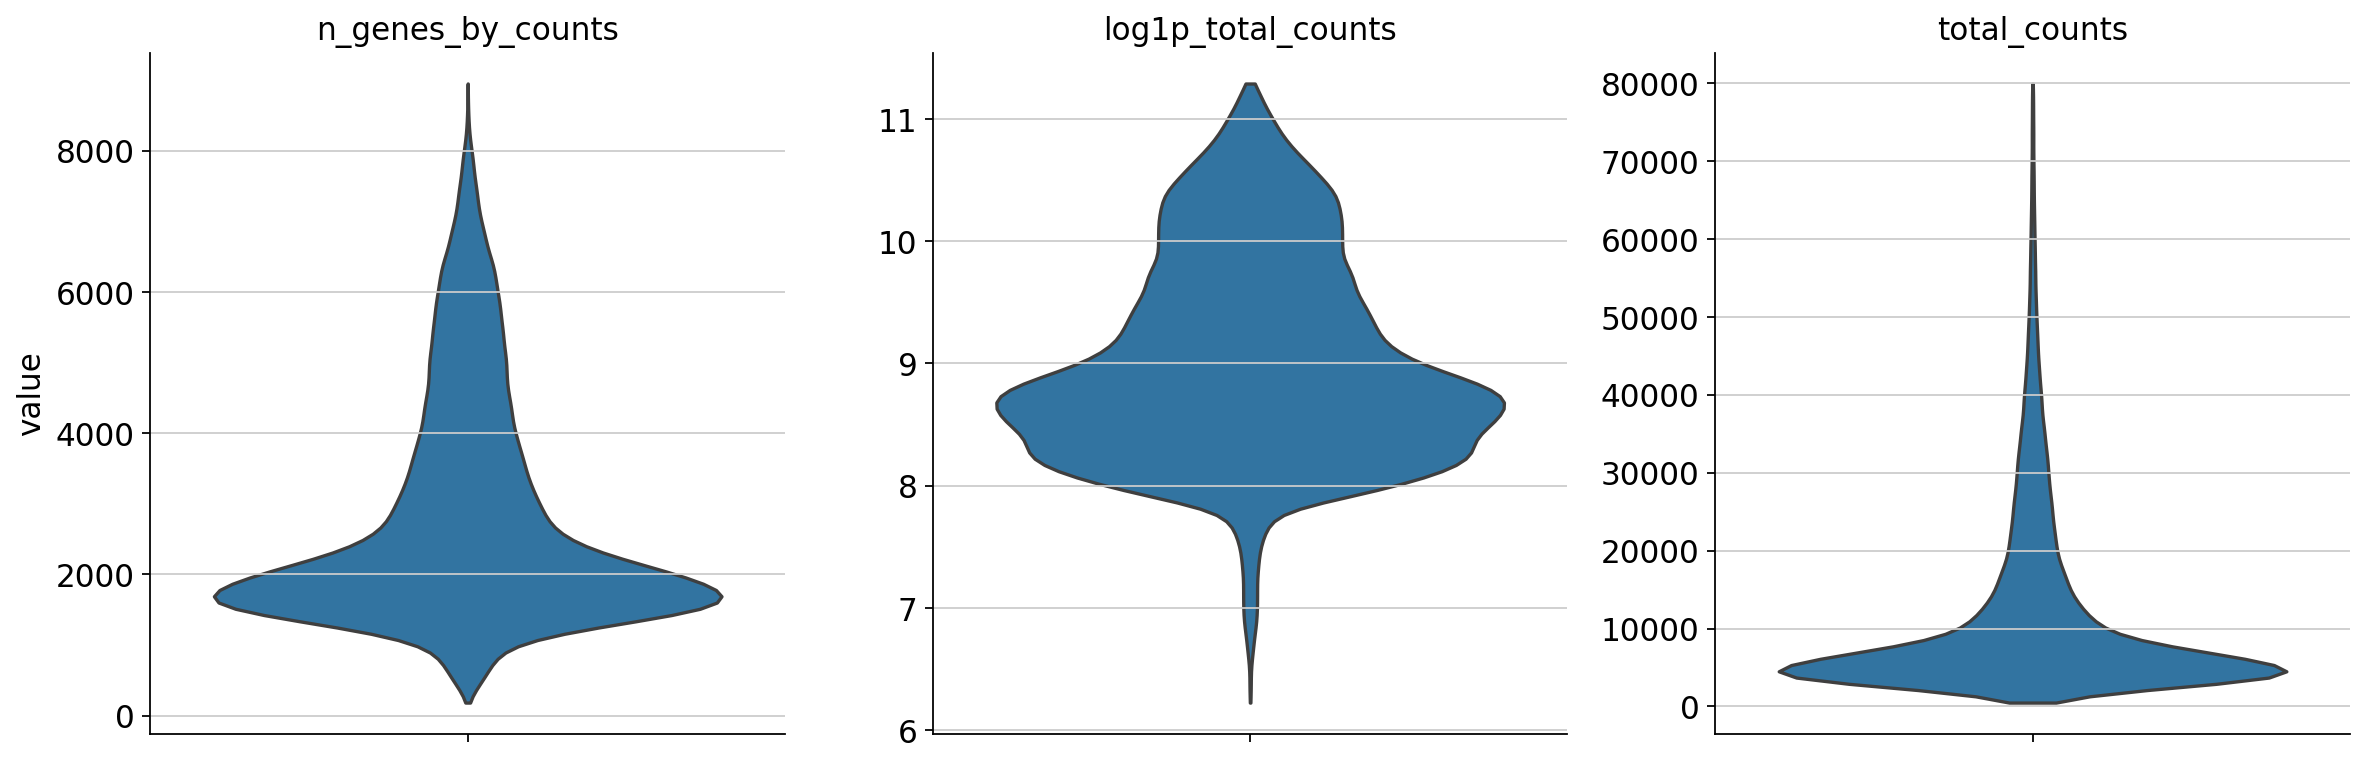

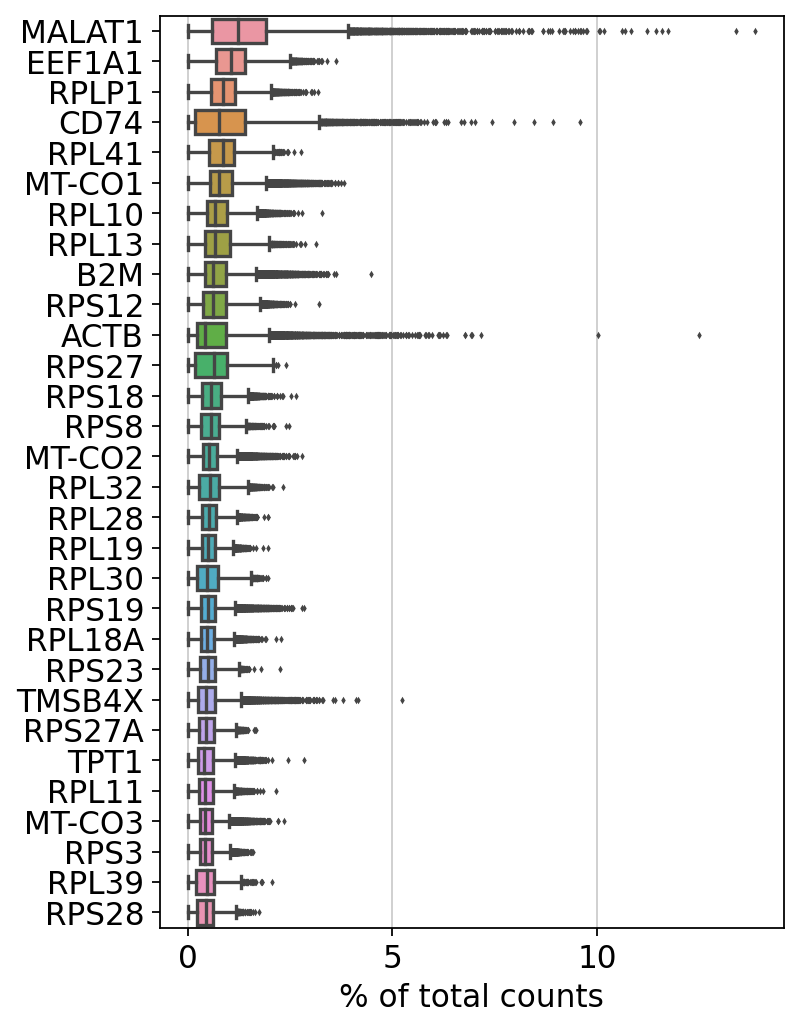

In [9]:
# generally this only filters out cells with > 9 % mito reads, which typically indicates they are dead
adata = perform_qc(adata)

In [10]:
def precluster_pp(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata, base = 2)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    sc.pl.highly_variable_genes(adata)
    adata.raw = adata
    sc.pp.scale(adata, max_value = 10)
    return adata

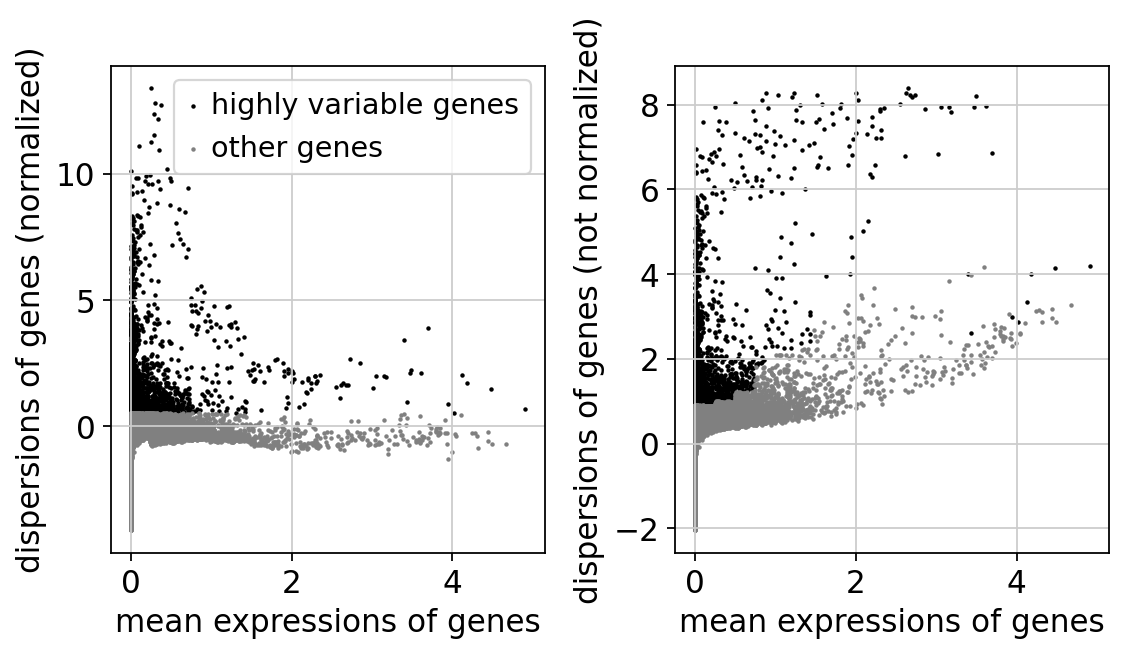

In [11]:
adata = precluster_pp(adata)

In [12]:
# remove variable igg genes which often drive clustering
adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False

# Cluster the data without batch correction

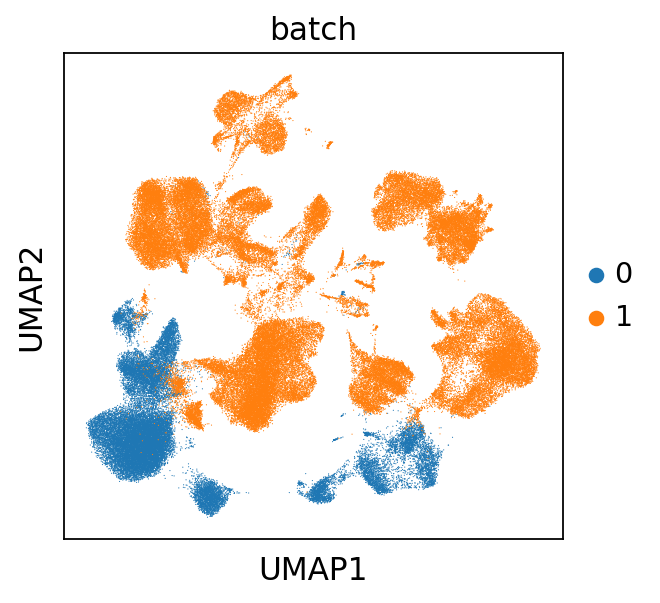

In [13]:

adata = cluster(adata, batch_correct=False, batch_key = 'tissue')

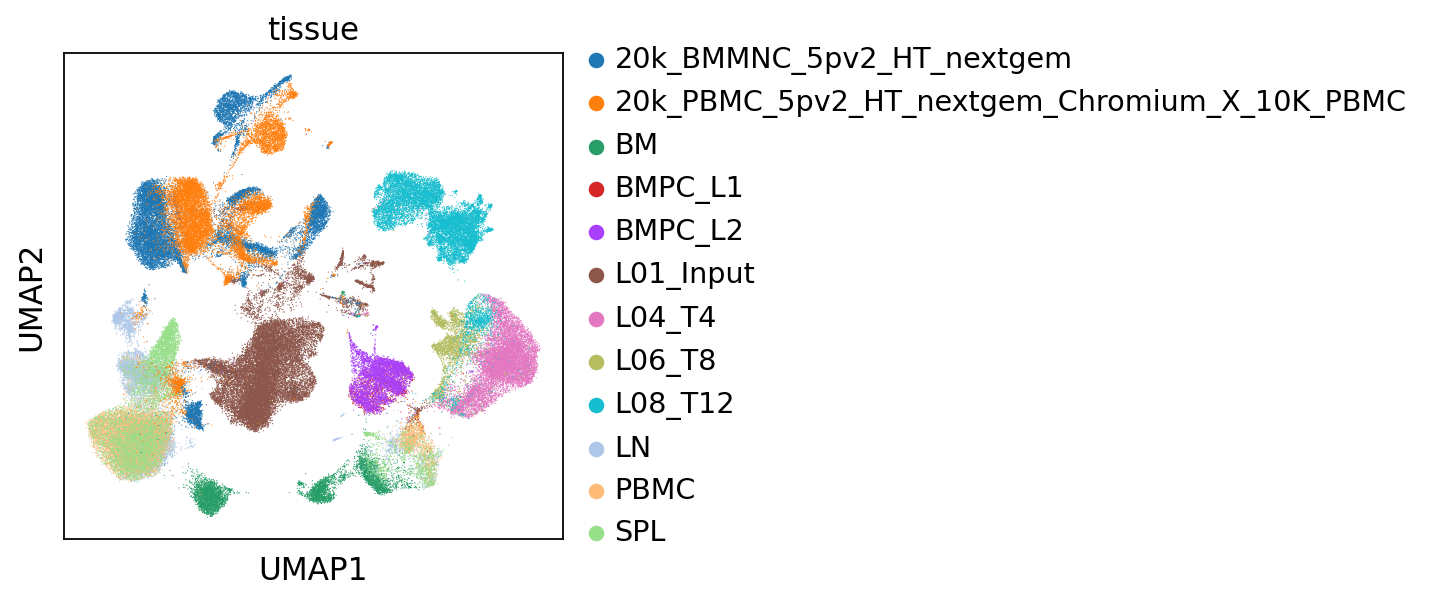

In [14]:
sc.pl.umap(adata, color = 'tissue')

## Use Celltypist

In [15]:
#Download all the available models.
#models.download_models()
#Update all models by re-downloading the latest versions if you think they may be outdated.
#models.download_models(force_update = True)

#Provide the input as an `AnnData`.
#predictions = celltypist.annotate('data/adata.h5ad', model = 'Immune_All_Low.pkl', majority_voting=True)
#Alteadatatively, the input can be specified as an `AnnData` already loaded in memory.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
# Celltypist Annotations to adata object
adata.obs['celltypist'] = predictions.predicted_labels.majority_voting

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 114918 cells and 30019 genes
🔗 Matching reference genes in the model
🧬 6099 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


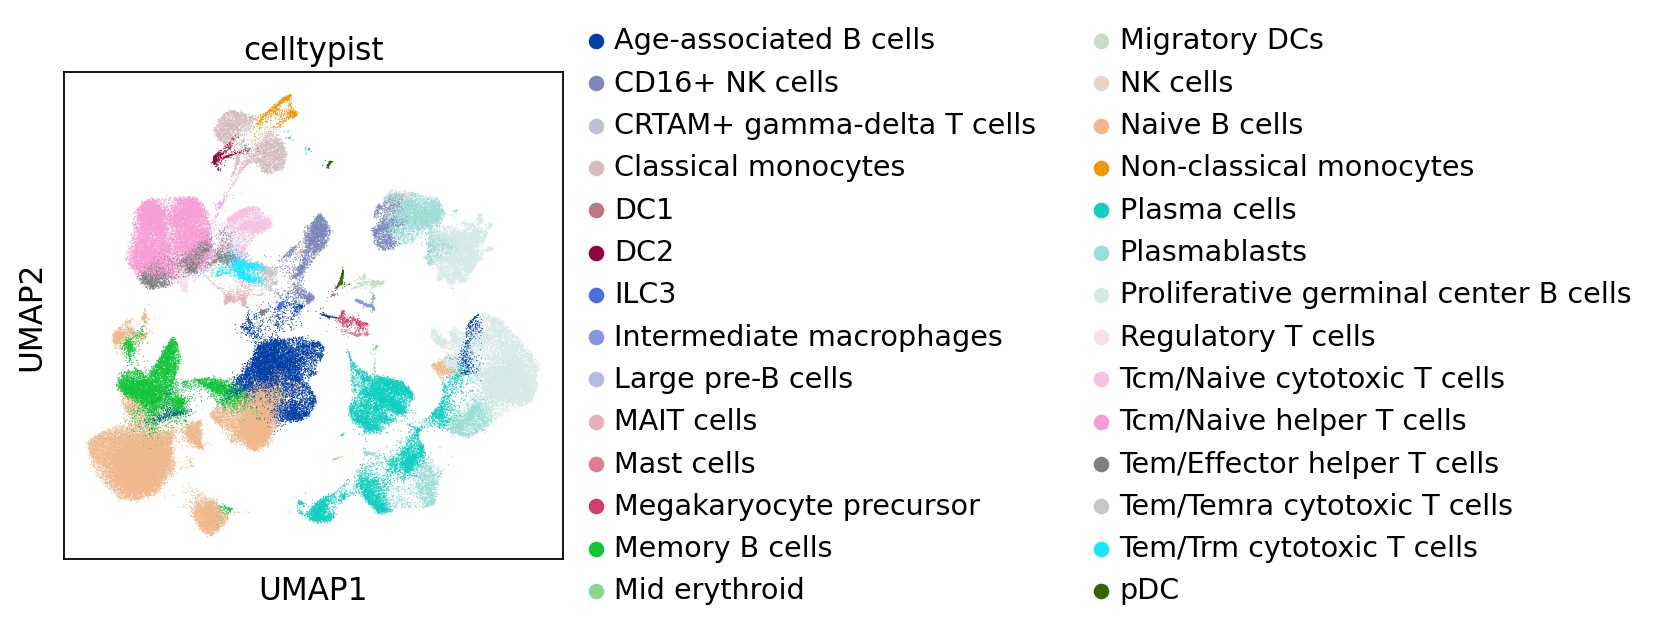

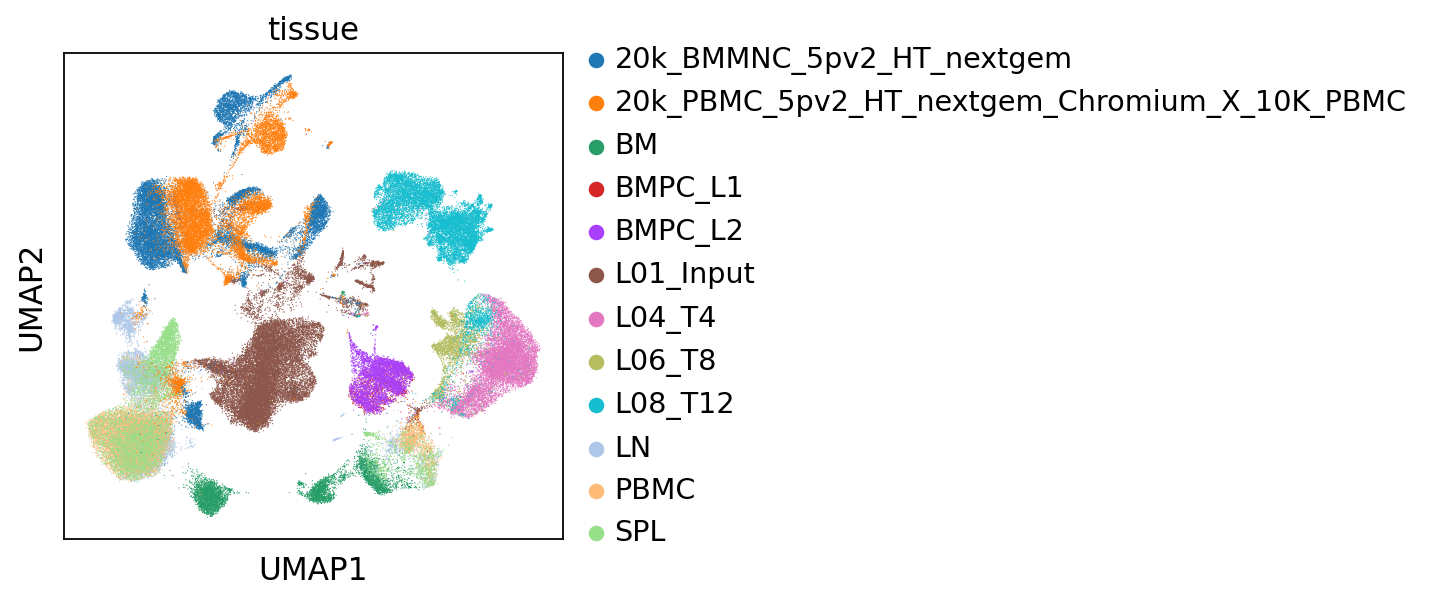

In [16]:
sc.pl.umap(adata, color = 'celltypist')
sc.pl.umap(adata, color = 'tissue')

In [17]:
# subset to b cell lineage
adata = adata[adata.obs.celltypist.str.contains('B cells|Plasma')]

In [18]:
adata.obs.celltypist = adata.obs.celltypist.cat.remove_unused_categories()

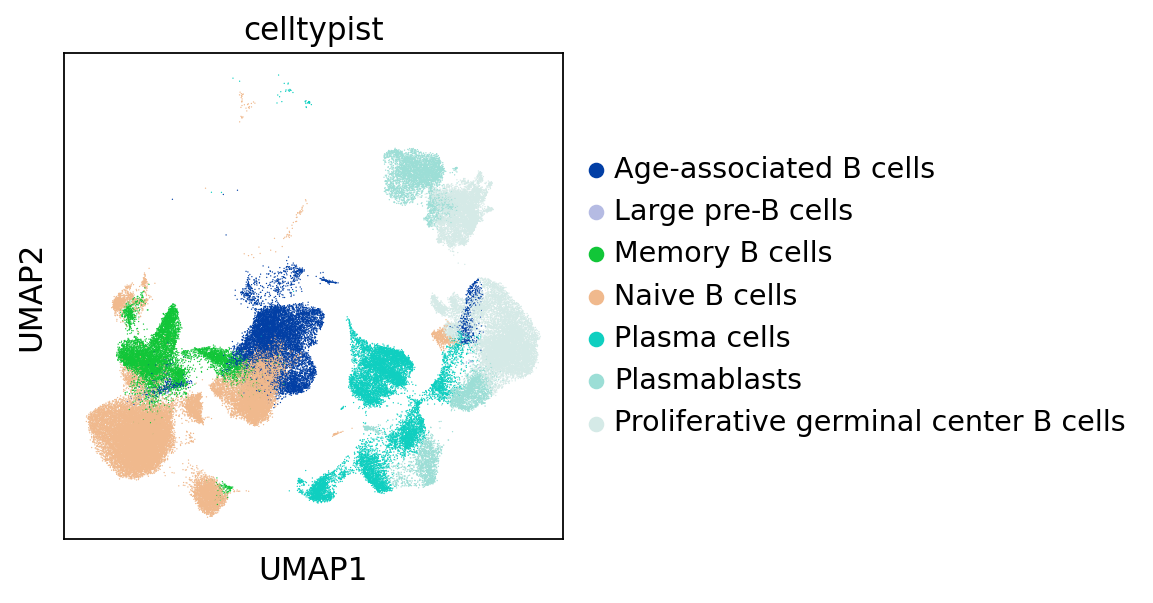

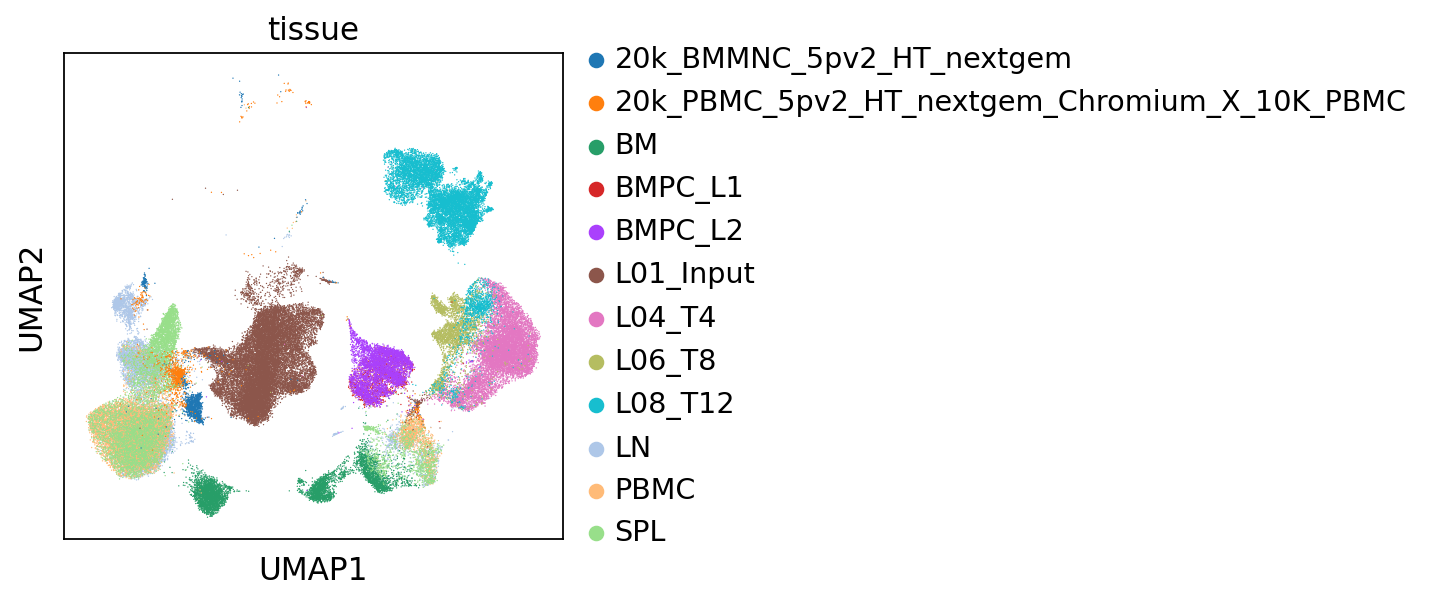

In [19]:
sc.pl.umap(adata, color = 'celltypist')
sc.pl.umap(adata, color = 'tissue')

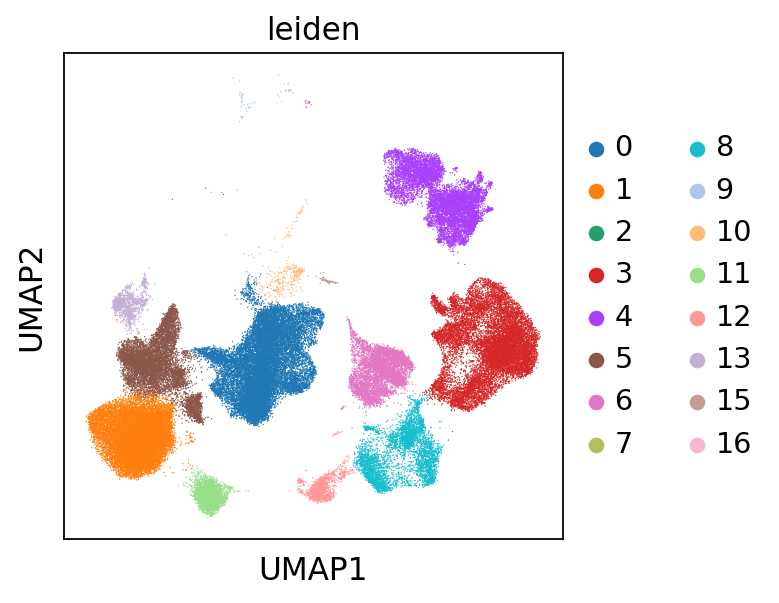

In [20]:
sc.pl.umap(adata, color = 'leiden')

My suspicion is that cluster 7 is not bona-fide plasma cells

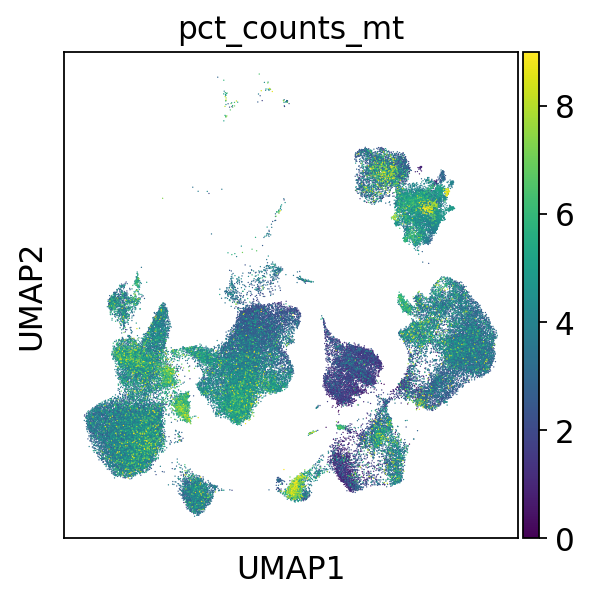

In [21]:
sc.pl.umap(adata, color = 'pct_counts_mt')

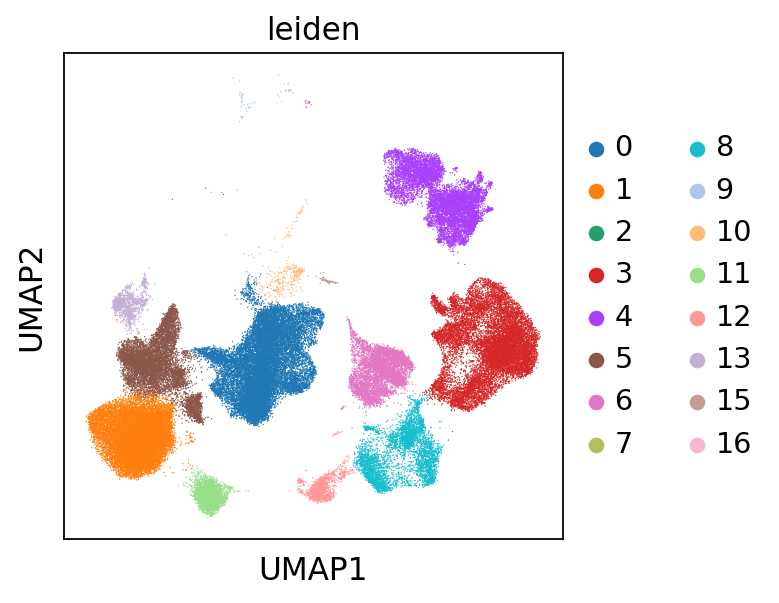

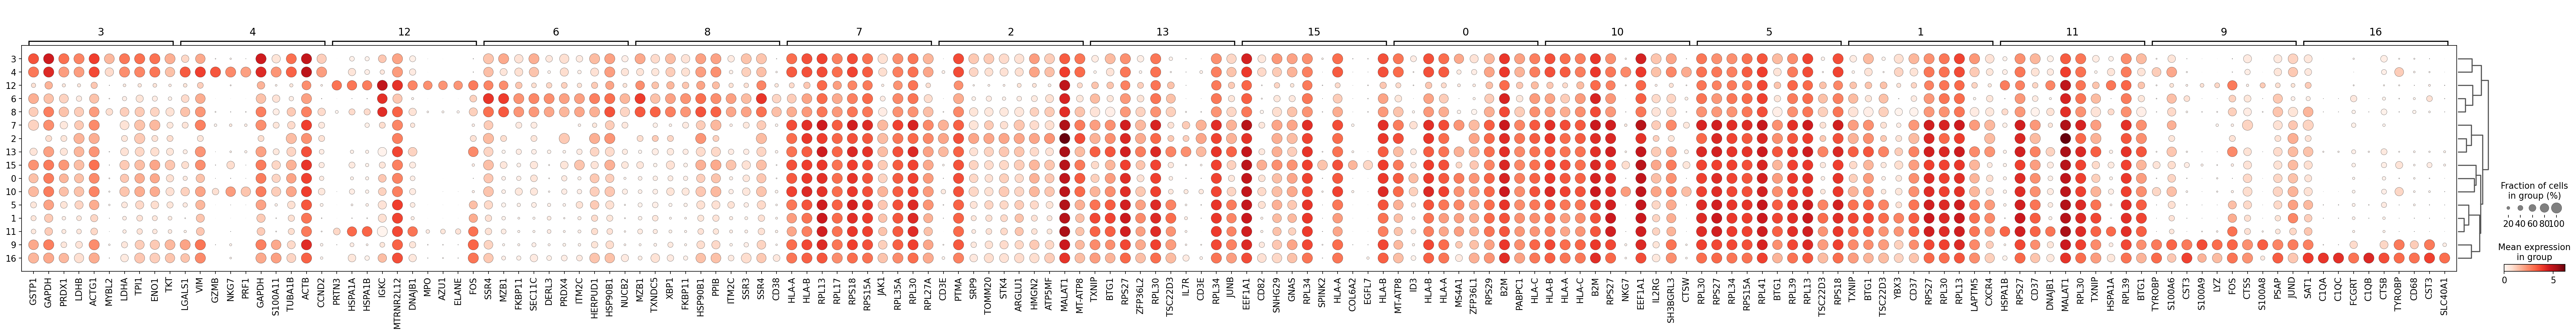

In [22]:
sc.pl.umap(adata, color='leiden')

sc.tl.rank_genes_groups(adata, groupby='leiden')

sc.tl.dendrogram(adata, groupby='leiden')

sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden')

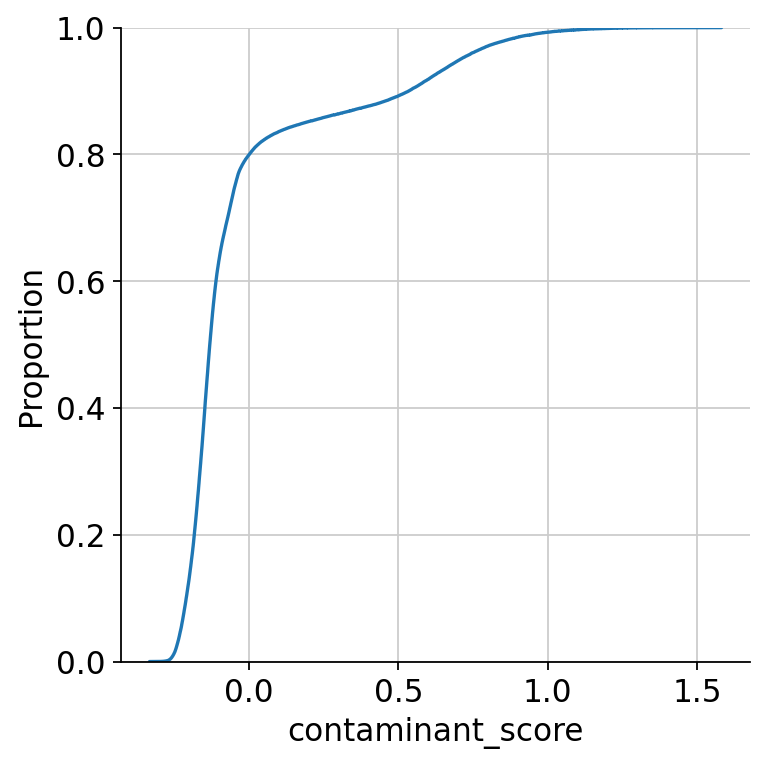

In [23]:
# non-B cell score, empirically defined from this plot, but could be done more rigourously 
genes = ['NKG7', 'GZMB', 'PRF1', 'SLC40A1', 'LYZ', 'TYROBP', 'CD3E', 'IL7R', 'AZU1', 'ELANE', 'MPO']

sc.tl.score_genes(adata, gene_list=genes, score_name='contaminant_score')

sns.displot(data = adata.obs, x = 'contaminant_score', kind = 'ecdf')

In [24]:
# removing leiden 4 which are dead cells / NK cells
# and leiden 2 & 8 which seem to have a lot of CD3,
# and leiden 10, 12 which also has quite a bit of perforin / SPINK2 / EGFL7 / ELANE which are NK or myeloid
adata.obs['ambient_gene_expression'] = adata.obs.leiden.isin(['4', '2', '10', '12', '16', '9'])

In [25]:
# create high ambient gene expression column
adata.obs['ambient_gene_expression'] = adata.obs['ambient_gene_expression'].astype(str)

... storing 'ambient_gene_expression' as categorical


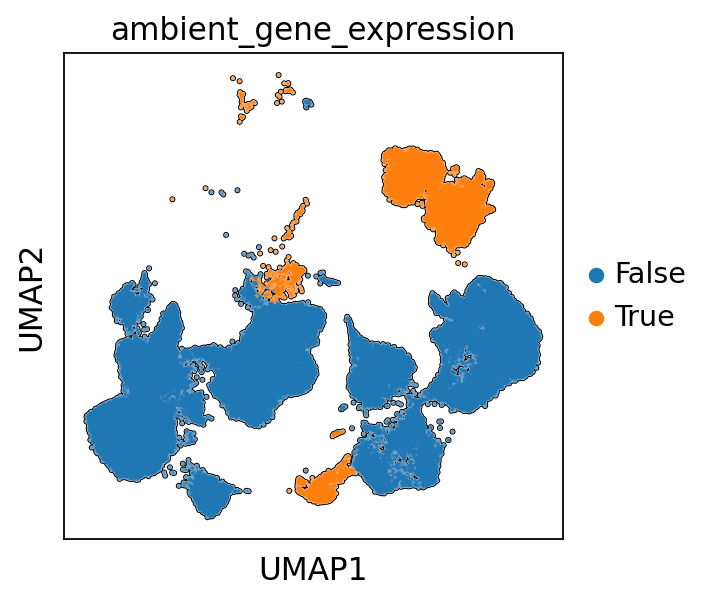

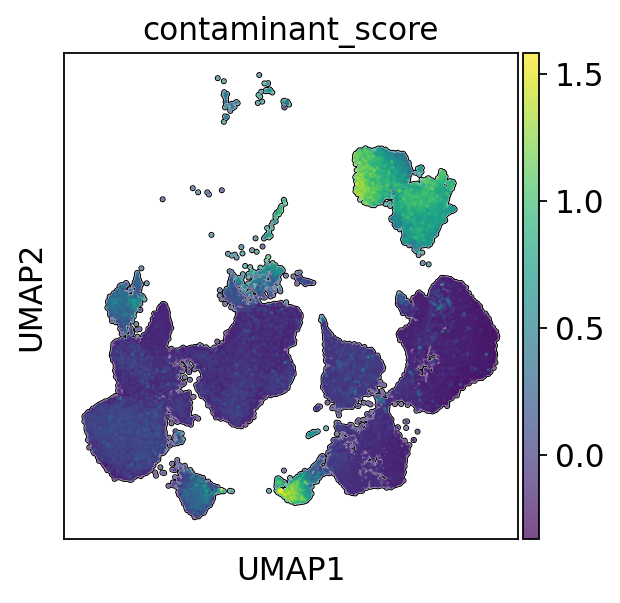

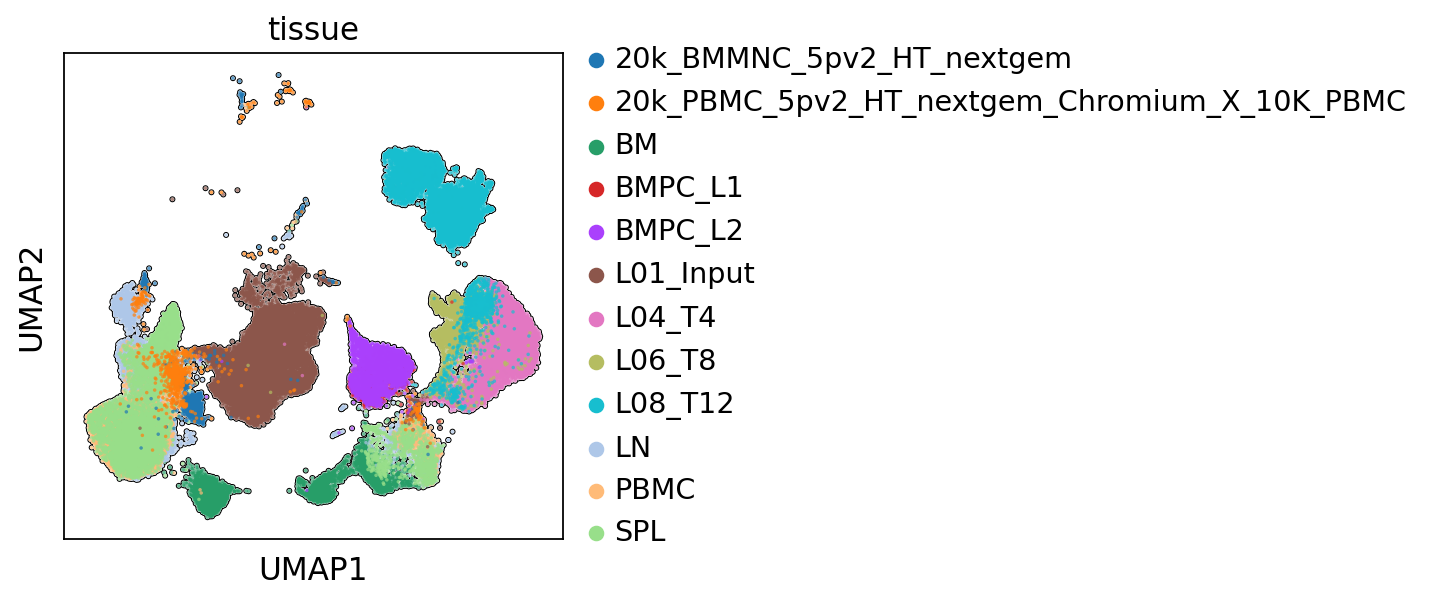

In [26]:
sc.pl.umap(adata, color = 'ambient_gene_expression', size = 10, add_outline=True)
sc.pl.umap(adata, color = 'contaminant_score', size = 10, add_outline=True)
sc.pl.umap(adata, color = 'tissue', size = 10, add_outline=True)

In [27]:
# check out total counts

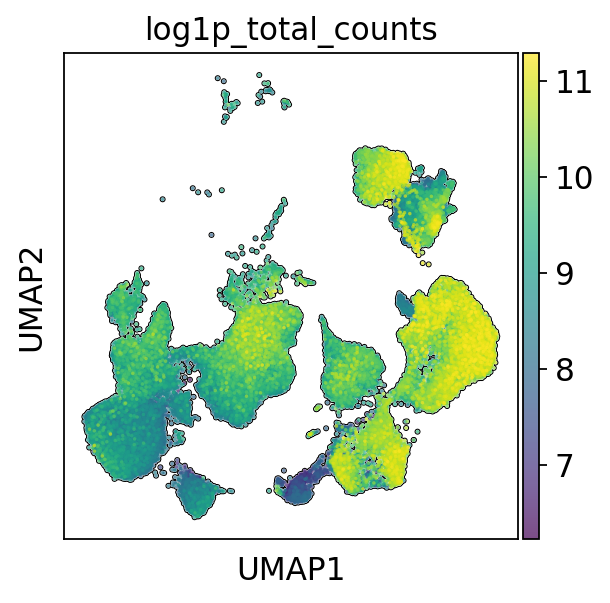

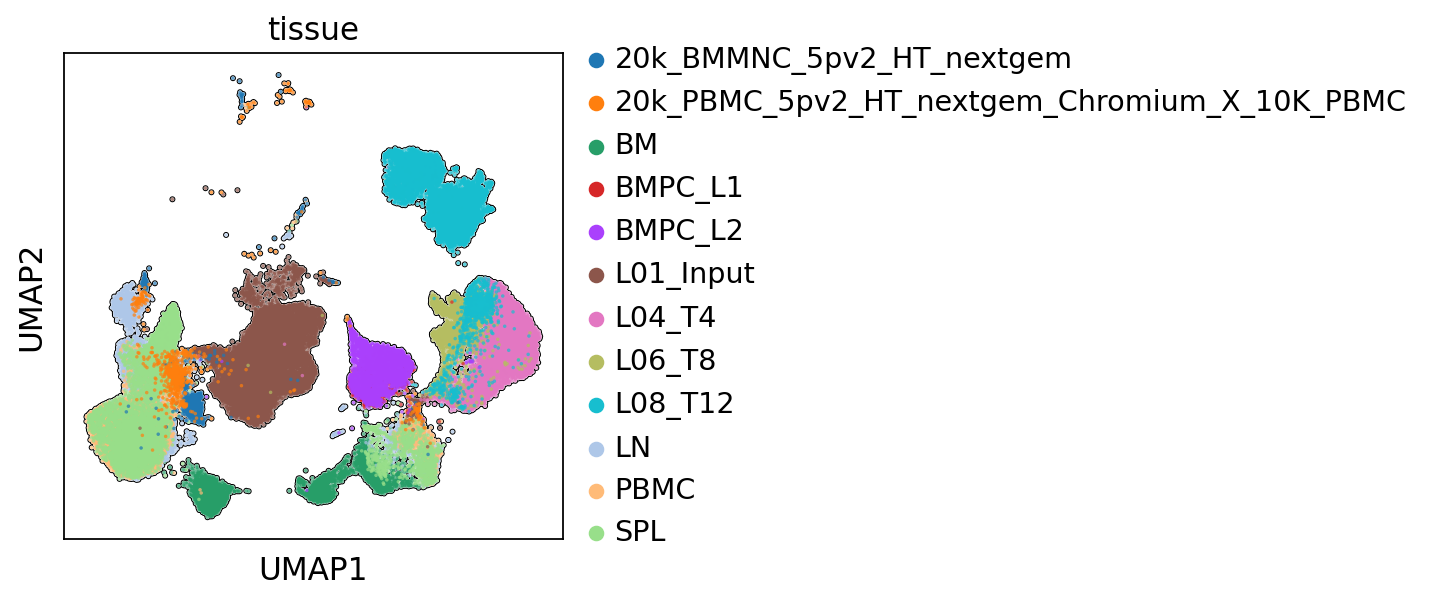

In [28]:
sc.pl.umap(adata, color = 'log1p_total_counts', size = 10, add_outline=True)
sc.pl.umap(adata, color = 'tissue', size = 10, add_outline=True)

In [29]:
# view actual distributions of counts (hump in lane 06 is odd for sure)

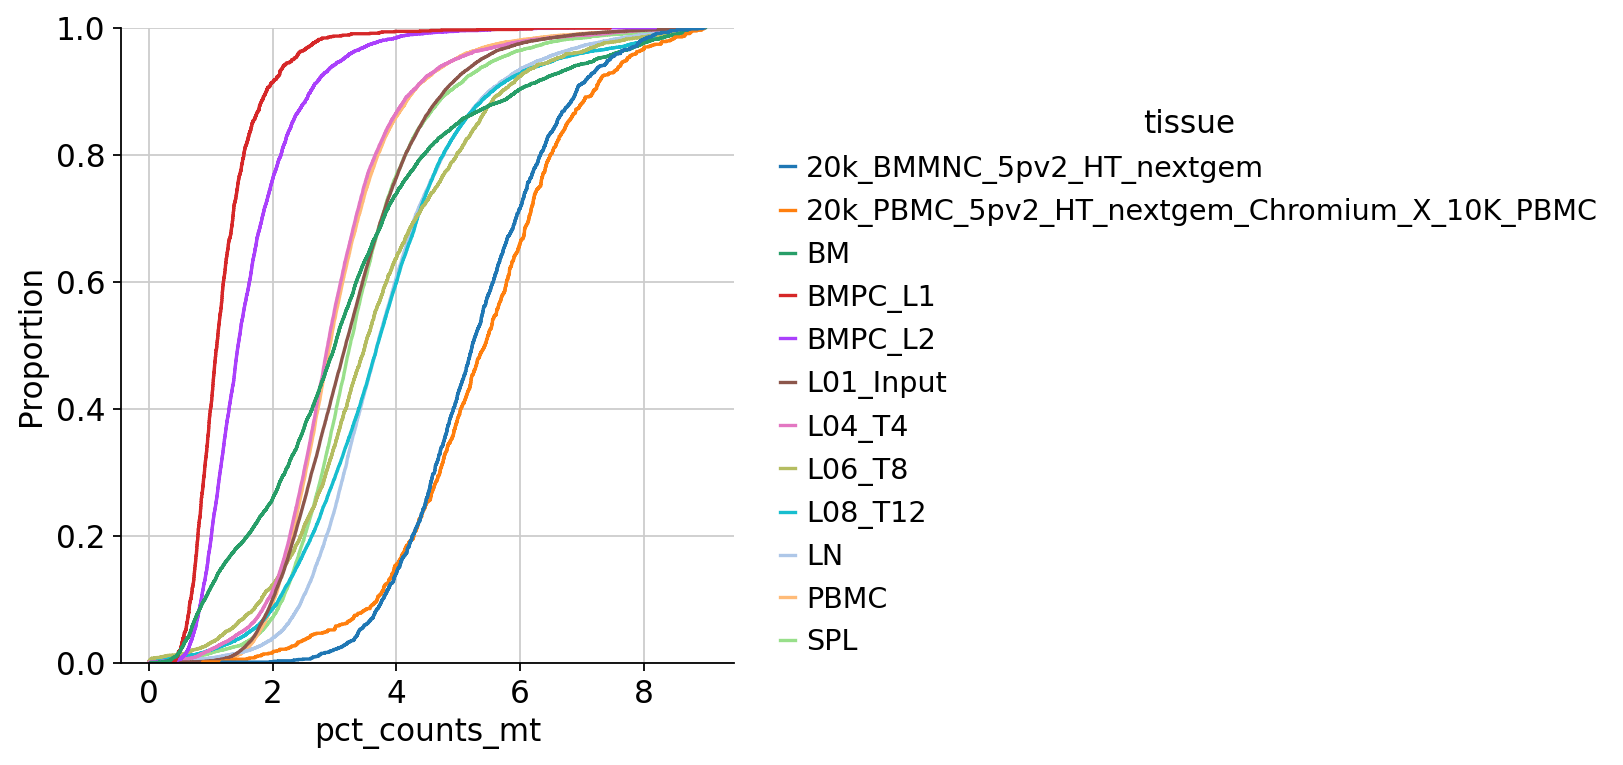

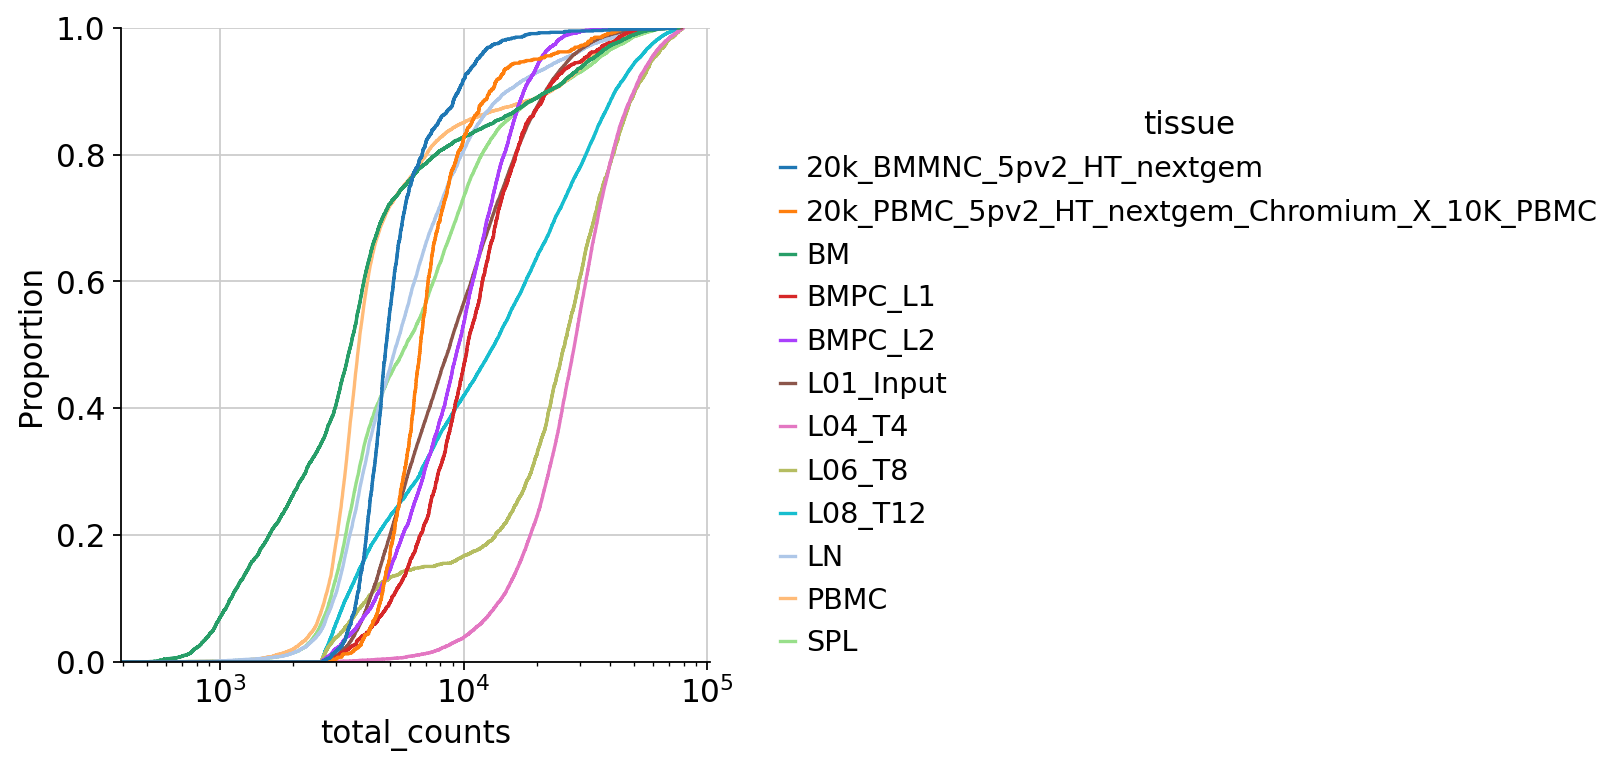

In [30]:
sns.displot(data = adata.obs, x='pct_counts_mt', kind='ecdf', hue = 'tissue')
sns.displot(data = adata.obs, x='total_counts', kind='ecdf', hue = 'tissue')
plt.xscale('log')

In [31]:
# low counts for a high quality b cell

In [32]:
adata.obs['low_counts'] = (adata.obs.total_counts < 2000).astype(str)

In [33]:
# even more stringent mito filtering

In [34]:
adata.obs['high_mito'] = (adata.obs.pct_counts_mt > 7).astype(str)

... storing 'low_counts' as categorical
... storing 'high_mito' as categorical


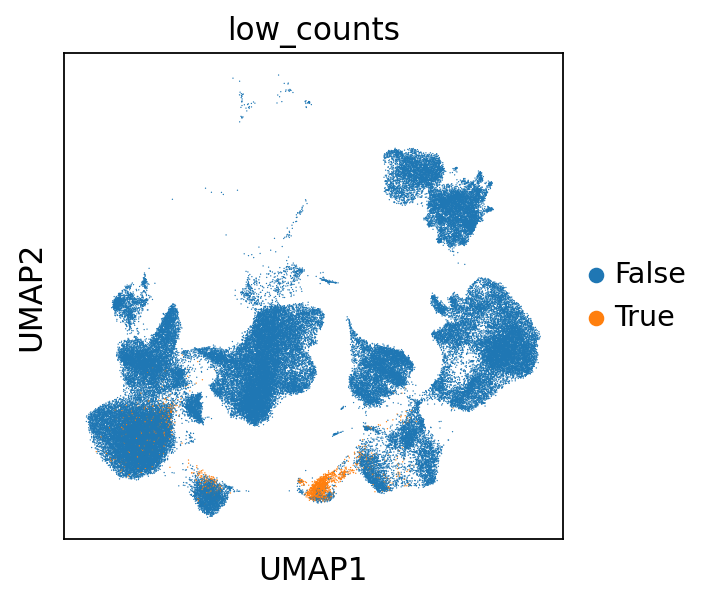

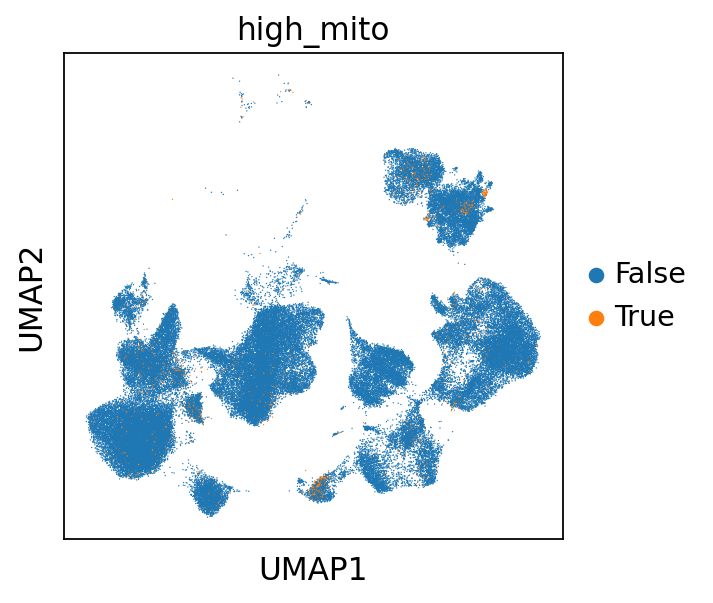

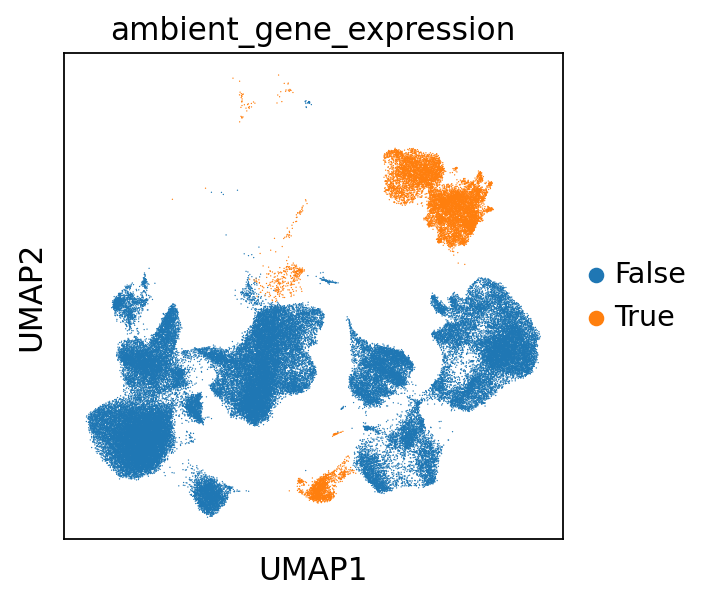

In [35]:
sc.pl.umap(adata, color = 'low_counts')
sc.pl.umap(adata, color = 'high_mito')
sc.pl.umap(adata, color = 'ambient_gene_expression')

In [36]:
# remove bad droplets
adata = adata[adata.obs['contaminant_score'] <= 0.0]

In [37]:
# batch correct and recluster

adata = cluster(adata, batch_correct=True, batch_key='tissue')

sc.tl.leiden(adata, resolution=1)

sc.pl.umap(adata, color='leiden')

sc.tl.rank_genes_groups(adata, groupby='leiden')

sc.tl.dendrogram(adata, groupby='leiden')

sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden')

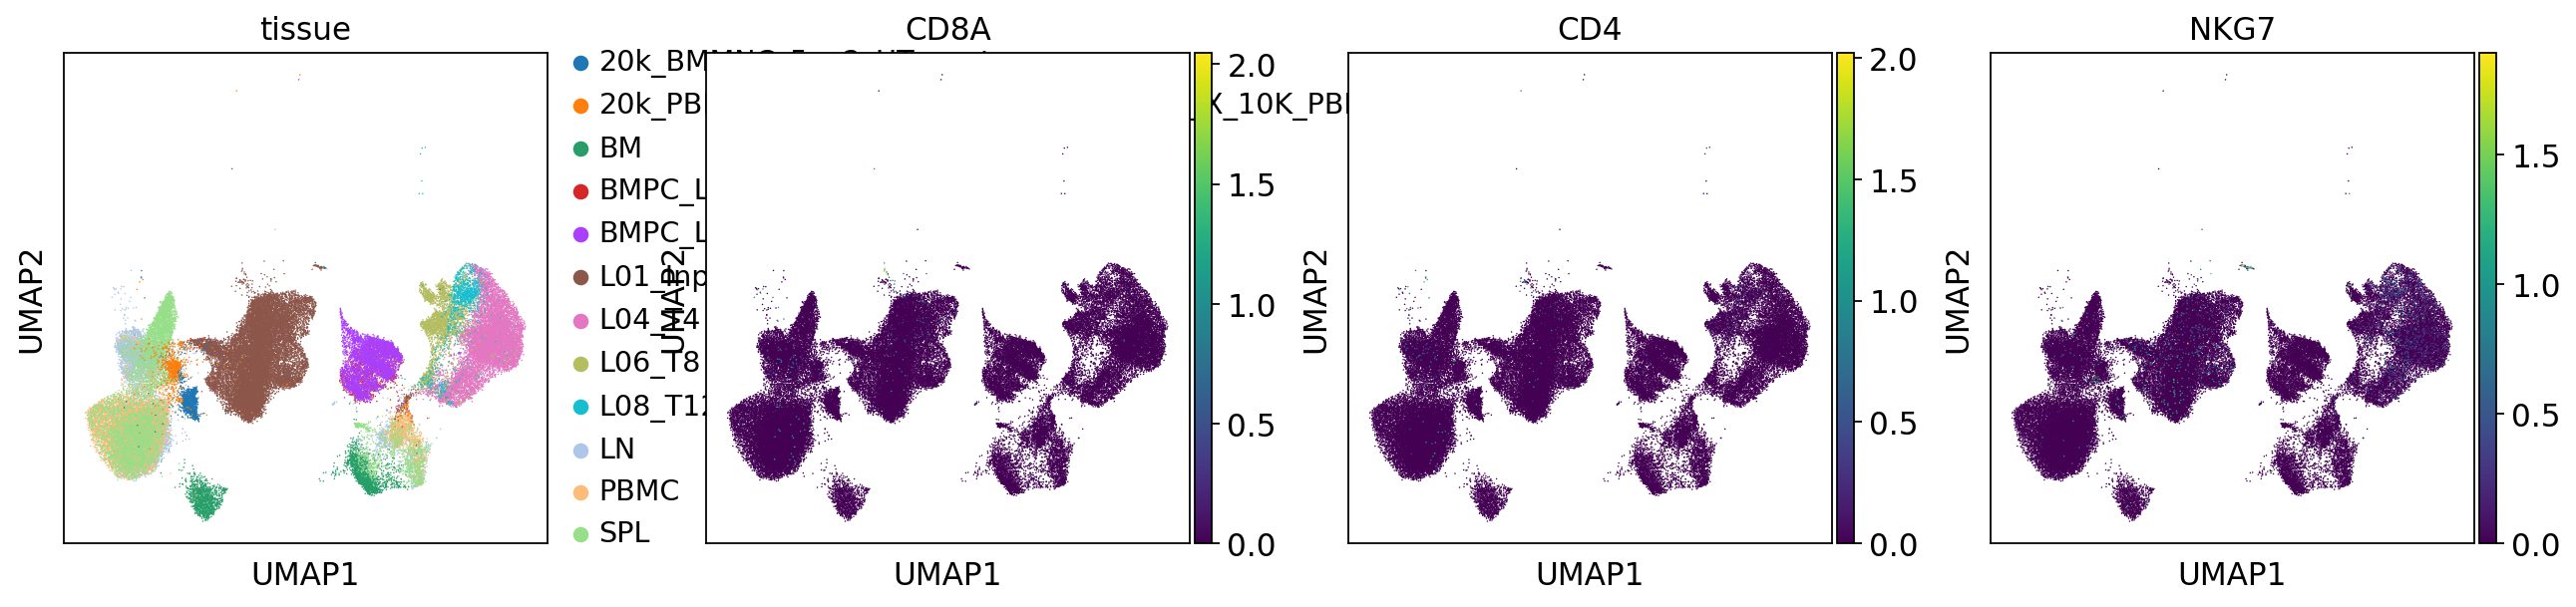

In [38]:
sc.pl.umap(adata, color = ['tissue', 'CD8A', 'CD4', 'NKG7'])

In [39]:
# I'm finding cluster 2 & 11 seems to have a lot of NK and T cell genes

In [ ]:
adata.obs['probable_t_cell_doublet'] = (adata.obs.leiden.isin(['11', '2'])).astype(str)

In [ ]:
sc.pl.umap(adata, color = 'probable_t_cell_doublet')

In [ ]:
adata.obs['true_b_cell'] = (adata.obs['low_counts'] == 'False') & (adata.obs['high_mito'] == 'False') & (adata.obs['ambient_gene_expression'] == 'False') & (adata.obs['probable_t_cell_doublet'] == 'False')
adata.obs['true_b_cell'].value_counts()

In [ ]:
adata.write_h5ad('../../data/processed_h5ad/filtered_adata.h5ad')

In [ ]:
adata.obs.groupby('true_b_cell').tissue.value_counts()

In [ ]:
# understand the failure modes:
    # dead cells
    # they look dead bc
    # there's these age-associated B cells but are they really?
    # the bone marrow seems stressed?
    # what kinds of artefacts exist